# PGExplainer on BA-Shapes dataset for 2-layer GCN

In [1]:
from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
import torch
from torch_geometric.data import DataLoader
from torch_geometric.data import Data, InMemoryDataset, download_url, extract_zip
import os.path as osp
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


### Load dataset

In [2]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

def split_dataset(dataset):
    indices = []
    num_classes = 4
    train_percent = 0.7
    for i in range(num_classes):
        index = (dataset.data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)

    train_index = torch.cat([i[:int(len(i) * train_percent)] for i in indices], dim=0)

    rest_index = torch.cat([i[int(len(i) * train_percent):] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
    dataset.data.val_mask = index_to_mask(rest_index[:len(rest_index) // 2], size=dataset.data.num_nodes)
    dataset.data.test_mask = index_to_mask(rest_index[len(rest_index) // 2:], size=dataset.data.num_nodes)

    dataset.data, dataset.slices = dataset.collate([dataset.data])

    return dataset

dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset.data.x = dataset.data.x.to(torch.float32)
dataset.data.x = dataset.data.x[:, :1]
# dataset.data.y = dataset.data.y[:, 2]
dim_node = dataset.num_node_features
dim_edge = dataset.num_edge_features
# num_targets = dataset.num_classes
num_classes = dataset.num_classes

splitted_dataset = split_dataset(dataset)
splitted_dataset.data.mask = splitted_dataset.data.test_mask
splitted_dataset.slices['mask'] = splitted_dataset.slices['train_mask']
dataloader = DataLoader(splitted_dataset, batch_size=1, shuffle=False)

### Load model and checkpoints

In [3]:
def check_checkpoints(root='./'):
    if osp.exists(osp.join(root, 'checkpoints')):
        return
    url = ('https://github.com/divelab/DIG_storage/raw/main/xgraph/checkpoints.zip')
    path = download_url(url, root)
    extract_zip(path, root)
    os.unlink(path)

model = GCN_2l(model_level='node', dim_node=dim_node, dim_hidden=300, num_classes=num_classes)
model.to(device)
check_checkpoints()
ckpt_path = osp.join('checkpoints', 'ba_shapes', 'GCN_2l', '0', 'GCN_2l_best.ckpt')
model.load_state_dict(torch.load(ckpt_path)['state_dict'])


<All keys matched successfully>

In [4]:
from dig.xgraph.method import SubgraphX
explainer = SubgraphX(model, num_classes=4, device=device, explain_graph=False)

### Visualization

explain graph node 356


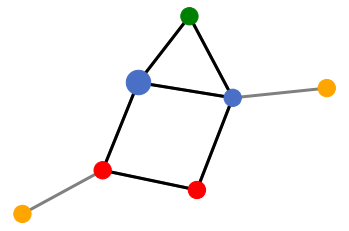

In [5]:
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector, ExplanationProcessor
x_collector = XCollector()

index = -1
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
data = dataset[0]

from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import find_closest_node_result, k_hop_subgraph_with_default_whole_graph
plotutils = PlotUtils(dataset_name='ba_shapes')

# Visualization
max_nodes = 5
node_idx = node_indices[6]
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()

_, explanation_results, related_preds = \
    explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)
result = find_closest_node_result(explanation_results[prediction], max_nodes=max_nodes)

plotutils = PlotUtils(dataset_name='ba_shapes')
explainer.visualization(explanation_results,
                        prediction,
                        max_nodes=max_nodes,
                        plot_utils=plotutils,
                        y=data.y)

### The metric result

In [6]:
max_nodes = 5
for node_idx in node_indices:
    index += 1
    print(f'explain graph node {node_idx}')
    data.to(device)

    if torch.isnan(data.y[0].squeeze()):
        continue

    logits = model(data.x, data.edge_index)
    prediction = logits[node_idx].argmax(-1).item()

    _, explanation_results, related_preds = \
        explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)
    result = find_closest_node_result(explanation_results[prediction], max_nodes=max_nodes)

    x_collector.collect_data(result.coalition, related_preds, label=prediction)
    if index >= 20:
        break

print(f'Fidelity: {x_collector.fidelity:.4f}\n'
      f'Sparsity: {x_collector.sparsity:.4f}')

explain graph node 302
explain graph node 313
explain graph node 321
explain graph node 332
explain graph node 336
explain graph node 348
explain graph node 356
explain graph node 367
explain graph node 369
explain graph node 381
explain graph node 387
explain graph node 418
explain graph node 454
explain graph node 461
explain graph node 466
explain graph node 469
explain graph node 471
explain graph node 497
explain graph node 508
explain graph node 514
explain graph node 515
Fidelity: 0.5462
Sparsity: 0.2373
